# Process the OT Data from Kris Bedka

## Imports

In [2]:
import xarray as xr
from distributed import LocalCluster, Client
import glob
import hvplot.xarray
import pyart
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import dask
import warnings
warnings.filterwarnings('ignore')

## Set which dates to read in

In [24]:
dates = [datetime(2018, 11, 29),
         datetime(2018, 12, 5),
        ]
search_patterns = [date.strftime('*%Y%m%d*') for date in dates]

In [21]:
from distributed import Client
client = Client()
client

2023-03-21 13:35:00,067 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/dask-worker-space/worker-ft35qliy', purging
2023-03-21 13:35:00,068 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/dask-worker-space/worker-0twwdxs5', purging
2023-03-21 13:35:00,068 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/dask-worker-space/worker-78ob8fo_', purging
2023-03-21 13:35:00,069 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/dask-worker-space/worker-aahe44me', purging
2023-03-21 13:35:00,069 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/dask-worker-space/worker-p9bsuwjm', purging


<Client: 'tcp://127.0.0.1:50654' processes=5 threads=10, memory=32.00 GiB>

In [25]:
for search_pattern in search_patterns[1:]:
    files = sorted(glob.glob(f"../../data/relampago-raw-ot-data/{search_pattern}"))
    ds = xr.open_mfdataset(files,
                           chunks={'time':120},
                           concat_dim='time',
                           combine='nested')
    
    # Add in the parallax correction
    ds["parallax_correction_latitude"] = ds.parallax_correction_latitude + ds.latitude
    ds["parallax_correction_longitude"] = ds.parallax_correction_longitude + ds.longitude
    ds = ds.set_coords(['parallax_correction_longitude',
                        'parallax_correction_latitude'])
    
    # Create an output file name from the time
    file_label = pd.to_datetime(ds.time.values[0]).strftime("ot_output_%Y%m%d.zarr")
    
    try:
        # Make sure the times are in a single chunk
        ds.chunk({'time':120}).to_zarr(f"../../data/cot-zarr/{file_label}")
    except:
        continue
        
    
    print("Done with: ", file_label)

Done with:  ot_output_20181205.zarr


In [36]:
day = '20181205'
ot_ds = xr.open_zarr(f"../../data/cot-zarr/ot_output_{day}.zarr")
ot_ds = ot_ds.rename({'parallax_correction_latitude':'lat',
                      'parallax_correction_longitude':'lon'})

ot_ds.time.attrs["long_name"] = 'time'
ot_prob = ot_ds.ot_probability.hvplot.quadmesh(x='lon',
                                               y='lat',
                                               groupby='time',
                                               clabel='OT Probability',
                                               rasterize=True,
                                               clim=(.5, 1),
                                               height=600,
                                               cmap='Spectral_r')

ir_bt = ot_ds.ir_brightness_temperature.hvplot.quadmesh(rasterize=True,
                                                        x='lon',
                                                        y='lat',
                                                        clabel='Channel 13 IR Brightness Temperature (K)',
                                                        groupby='time',
                                                        cmap='Spectral_r',
                                                        clim=(190, 290),
                                                        height=600)

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


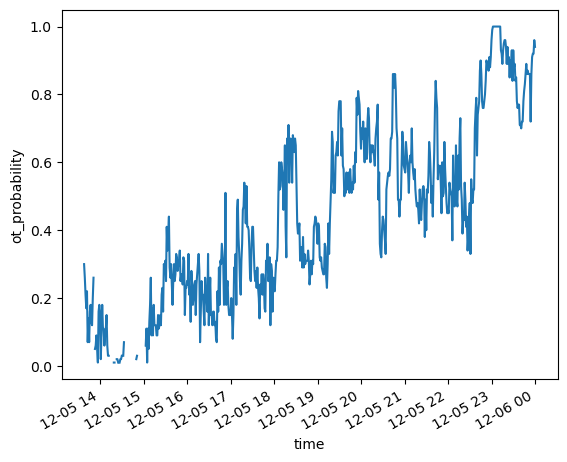

In [34]:
ot_ds.ot_probability.max(dim=['nlines', 'npixels']).plot()

In [37]:
(ot_prob + ir_bt).cols(1)

:Layout
   .DynamicMap.I  :DynamicMap   [time]
      :Image   [lon,lat]   (ot_probability)
   .DynamicMap.II :DynamicMap   [time]
      :Image   [lon,lat]   (ir_brightness_temperature)